# Tutorial : ElegantRun - Tracking

In [1]:
import pandas as pd
import numpy as np

from pyelegantsdds.elegantrun import ElegantRun
from pyelegantsdds.sdds import SDDS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

from IPython.display import Image

In [2]:
# path to singularity container with parallel elegant installed
sif = "PATH_TO_SIF"

## Lattices used in the tutorial

### FODO

In [3]:
### lattice element definitions
elements ={
    "QF": {"type" : "KQUAD", "L": 0.342, "K1":  0.4900, "N_KICKS": 16},
    "QD": {"type" : "KQUAD", "L": 0.668, "K1": -0.4999, "N_KICKS": 16},
    "D":  {"type" : "DRIF" , "L": 3.5805},
    "W1": {"type" : "WATCH", "filename":"\"%s-%03ld.w1\"","mode": "coordinates"}
}

FODOstr    = "! FODO cell.\n\n"
stringlist = ["{:6}: {}".format(k,", ".join([
    "{}={:15.12f}".format(kk,vv) 
    if not isinstance(vv,str) 
    else "{}={}".format(kk,vv)
    if kk!="type" 
    else "{}".format(vv) 
    for kk,vv in v.items()])) 
              for k,v in elements.items()]

line     = ["W1","QF","D","QD","D","QF"]
linestr  = "{:6}: LINE=({})".format("FODO",",".join(line))

FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

print(FODOstr)

with open("FODO.lte","w") as f:
    f.write(FODOstr)

! FODO cell.

QF    : KQUAD, L= 0.342000000000, K1= 0.490000000000, N_KICKS=16.000000000000
QD    : KQUAD, L= 0.668000000000, K1=-0.499900000000, N_KICKS=16.000000000000
D     : DRIF, L= 3.580500000000
W1    : WATCH, filename="%s-%03ld.w1", mode=coordinates

FODO  : LINE=(W1,QF,D,QD,D,QF)


### parTrack from Elegant examples

In [4]:
# Lattice parTrack from Elegant examples
latstr = """
l1a: DRIF, L=0.2
l1b: DRIF, L=1.531675
lqb: DRIF, L=0.24
l2:  DRIF, L=0.08
l3:  DRIF, L=1.47
l3a: DRIF, L=0.568095770758662
l3b: DRIF, L=0.551904229241338

! LHK is half the effective length of a kicker
lhk:  DRIF, L=0.175
l34a: DRIF, L=0.811087
l34b: DRIF, L=0.308913

l4: DRIF, L=0.08
l5: DRIF, L=0.325

b1: CSBEND, L=0.8, angle=-0.785398163397, e1=-0.445, e2=-0.445, k2=0.1375, k3=100, hgap=0.0225, fint=0.41, integration_order=4, n_kicks=20, nonlinear=1
b2: CSBEND, L=0.8, angle=-0.785398163397, e1=-0.445, e2=-0.445, k2=0.1375, k3=100, hgap=0.0225, fint=0.41, integration_order=4, n_kicks=20, nonlinear=1

q1: KQUAD, L=0.23, k1=1.786022448154, n_kicks=10
q2: KQUAD, L=0.23, k1=2.295915530046, n_kicks=10
q3: KQUAD, l=0.23, k1=0.0
q4: KQUAD, l=0.23, k1=2.270174600496, n_kicks=10

s1h: SEXT, l=0.1, k2=0.0

! vertical chromaticity sextupole plus vertical steering magnet
sdh: KSEXT, l=0.1, k2=5.95873739969822, n_kicks=4

! horizontal chromaticity sextupole plus horizontal steering magnet
sfh: ksextupole, l=0.1, k2=-1.65546424863732, n_kicks=4

s1: line=(s1h,s1h)
sd: line=(sdh,sdh)
sf: line=(sfh,sfh)

! markers for the septum center and the center of the RF straight
msept: marker
mrf:   marker

! quadrant 1, less half of SF
quadr1: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3a,lhk,lhk,l3b,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 2, less half of SF
quadr2: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3a,lhk,lhk,l3b,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 3, less half of SF
quadr3: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l3,sd,l4,q3,lqb,b2,lqb,q4,l5)

! quadrant 4, less half of SF
quadr4: line=(l1a,l1b,s1,l2,q1,lqb,b1,lqb,q2,l34a,lhk,lhk,l34b,sd,l4,q3,lqb,b2,lqb,q4,l5)

half: line=(quadr2,sf,-quadr2)

ap: rcol,x_max=0.04,y_max=0.01
par: line=(2*half,ap)
return

""".upper()

with open('parTrack.lte','w') as f:
    f.write(latstr)

## Tracking

### Single particle tracking simple

In [5]:
# set lattice for the rest of the tutorial
lattice = "FODO.lte"

# create instance of the class
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)

# run tracking of single particle with given init coord.
er.simple_single_particle_track(n_passes=2**8, coord=np.array([1e-5,0,0,0,0]))

1700.0
Shape: (1, 6) - Number of paritcles: 1 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [6]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    graph="symb,type=1,fill",
    device='png',
    output="FODO_single_particle.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.w1 -columnNames=x,xp -graph=symb,type=1,fill -device=png -output=FODO_single_particle.png


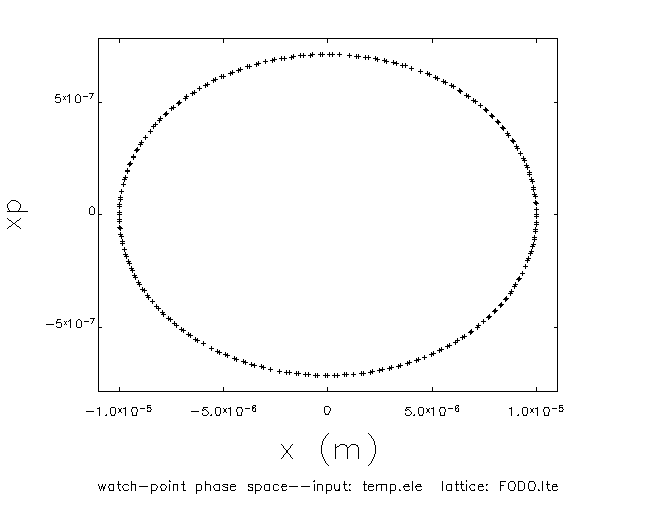

In [7]:
Image(filename='FODO_single_particle.png') 

### Multi-particle Tracking

Before tracking we need to decide on which initial distribution to track. The package offers several possibilities to generate initial distributions.

#### Hypercube

In [8]:
# generate rectangular coordinate input file - auto
# if pcentralmev is not given the energy value in er.kwargs will be used
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=7
                                   )

1700.0
Shape: (16807, 6) - Number of paritcles: 16807 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


Let us have a look at a 3D cut of the initial distribution.

Warning - auto filename set
Changed from temp_particles_input.bin to temp_particles_input.bin.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


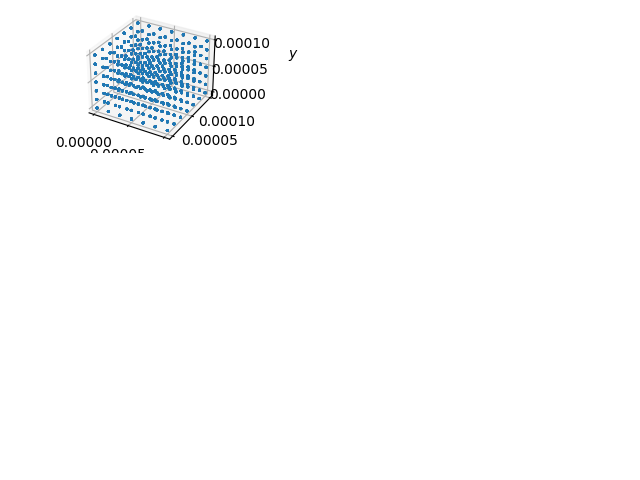

In [9]:
sddsp = SDDS(sif,"temp_particles_input.bin",0)
df    = sddsp.readParticleData()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.x,df.xp,df.y,s=1)

# labels
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')

# padding
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

plt.tight_layout()
plt.show()

In [10]:
# track
er.track_simple(n_passes=2**6)

In [11]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device='png',
    output="FODO_multi_particle_rectangular.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.w1 -columnNames=x,xp -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=FODO_multi_particle_rectangular.png


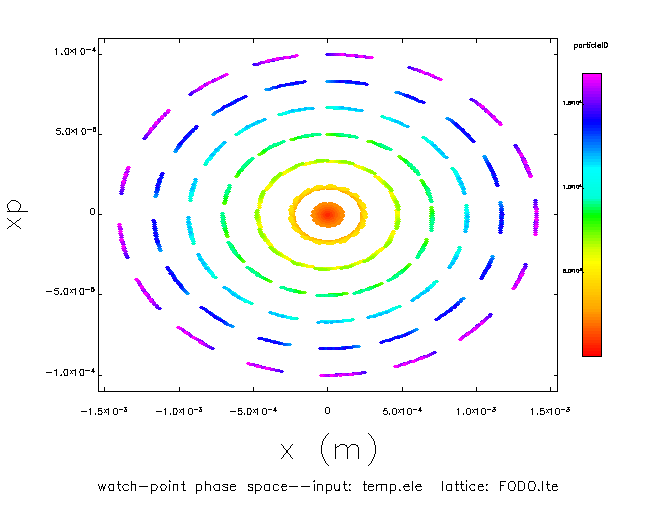

In [12]:
Image(filename="FODO_multi_particle_rectangular.png")

#### Higher dim ball

In [13]:
# generate rectangular coordinate input file - auto
# if pcentralmev is not given the energy value in er.kwargs will be used
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
er.generate_sdds_particle_inputfile(grid_type='spherical',  
                                    dim=6,
                                    rmin=1e-6,
                                    rmax=1e-4,
                                    rsteps=5,
                                    phisteps=10,
                                    half=False, # True gives full first quadrant
                                    pcentralmev=er.kwargs.get('energy'),
                                   )

1700.0
Shape: (5000, 6) - Number of paritcles: 5000 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


Warning - auto filename set
Changed from temp_particles_input.bin to temp_particles_input.bin.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


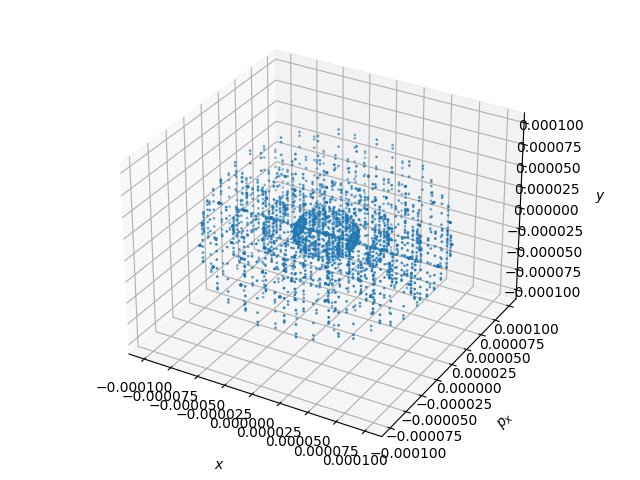

In [14]:
sddsp = SDDS(sif,"temp_particles_input.bin",0)
df = sddsp.readParticleData()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

ax.scatter(df.x,df.xp,df.y,s=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')
plt.tight_layout()
plt.show()

In [15]:
# generate rectangular coordinate input file - auto
# if pcentralmev is not given the energy value in er.kwargs will be used
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
er.generate_sdds_particle_inputfile(grid_type='spherical',  
                                    dim=6,
                                    rmin=1e-6,
                                    rmax=1e-4,
                                    rsteps=5,
                                    phisteps=10,
                                    half=True, # False gives full spheres
                                    pcentralmev=er.kwargs.get('energy'),
                                   )

1700.0
Shape: (5000, 6) - Number of paritcles: 5000 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


Warning - auto filename set
Changed from temp_particles_input.bin to temp_particles_input.bin.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


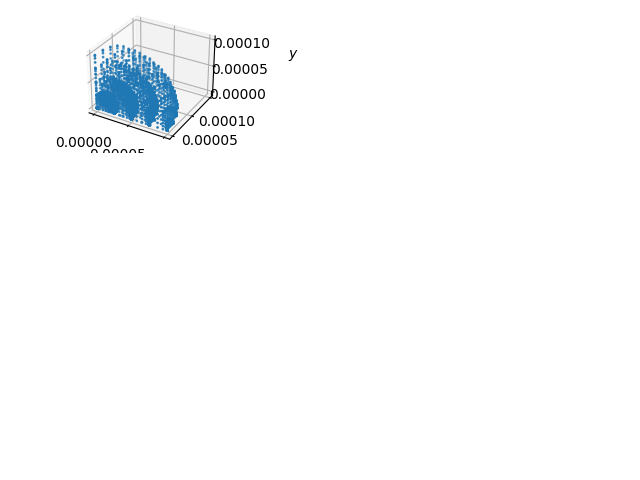

In [16]:
sddsp = SDDS(sif,"temp_particles_input.bin",0)
df = sddsp.readParticleData()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

ax.scatter(df.x,df.xp,df.y,s=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')
plt.tight_layout()
plt.show()

In [17]:
# track
er.track_simple(n_passes=2)

Warning - auto filename set
Changed from temp-001.w1 to temp-001.w1.txt
Warning - auto filetype set
Changed from 0 to 1


<IPython.core.display.Javascript object>


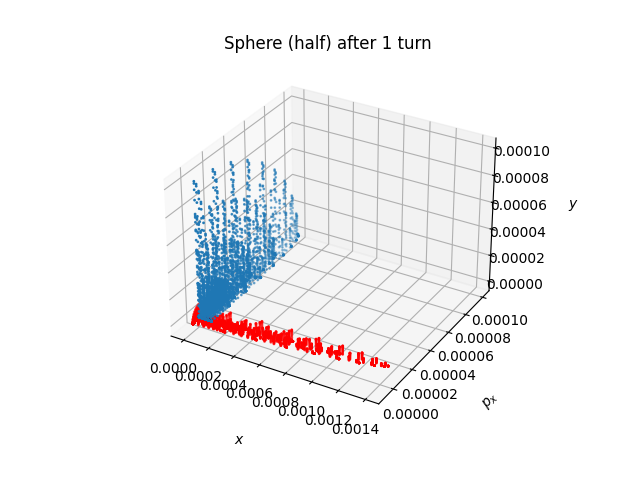

In [18]:
sddsp = SDDS(sif,"temp-001.w1",0)
df = sddsp.readParticleData()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.loc[df.Turn==1].x,df.loc[df.Turn==1].xp,df.loc[df.Turn==1].y,s=1)
ax.scatter(df.loc[df.Turn==2].x,df.loc[df.Turn==2].xp,df.loc[df.Turn==2].y,s=1,c='red')

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=15

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_zlabel(r'$y$')

plt.title('Sphere (half) after 1 turn')
plt.show()

#### Manual distribution

In [19]:
# load elegant similator
er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)

# twiss
twidata, twipar = er.findtwiss()
twipar.nux, twipar.nuy, twipar['dnux/dp'], twipar['dnuy/dp']

(0.2357264, 0.2343325, -0.2898536, -0.2892501)

In [20]:
# off - momentum
delta = 1.5e-3 * twipar.pCentral

# initial coordinate grid for tracking
man_ranges= {
    0 : np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0.05],
    2 : 0,
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

# generate coordinate input file
er.generate_sdds_particle_inputfile(man_ranges=man_ranges)

# track
er.track_simple(n_passes=400)

1700.0
Shape: (24, 6) - Number of paritcles: 24 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [21]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

# uncomment to save to file
sddsp.sddsplot_base(
    columnNames="x,xp",
#     file="temp-001.w1",
    scale="-2.5,2.5,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="FODO_island.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.w1 -columnNames=x,xp -scale=-2.5,2.5,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=FODO_island.png


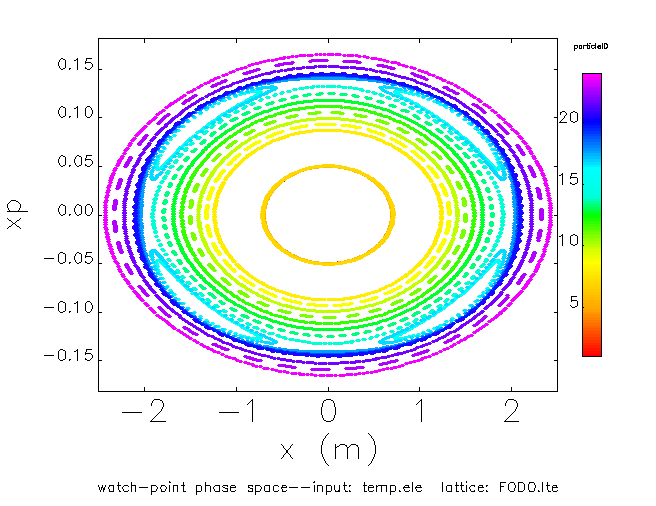

In [22]:
Image(filename="FODO_island.png")

## Advanced Tracking

### FMA

In [23]:
lattice = 'parTrack.lte'
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)
er.fma(xmin=-0.05,xmax=0.05,ymin=0,ymax=0.02,nx=51,ny=51, n_passes=256)

In [24]:
sddsp = SDDS(sif,'temp.fma',0)
sddsp.sddsplot_fma(
#     file2="temp.fma",
    device='png',
    output="partrack_fma_diffusionrate.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp.fma -col=x,y -graph=sym,vary=subtype,fill,scale=2,fill -order=spectral -split=column=diffusionRate -device=png -output=partrack_fma_diffusionrate.png


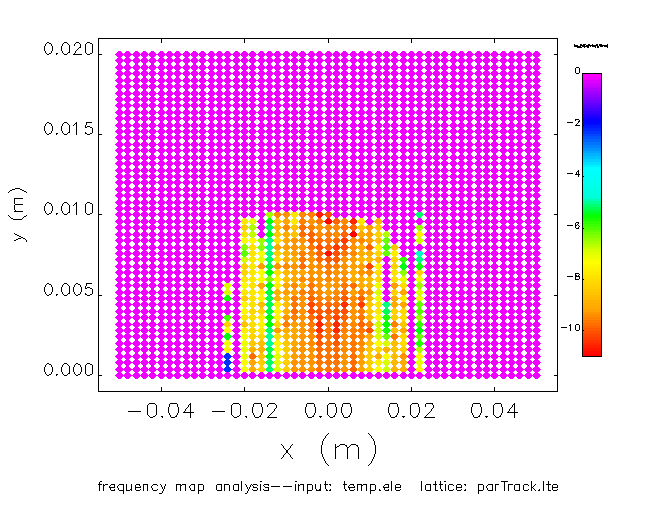

In [25]:
Image(filename="partrack_fma_diffusionrate.png")

In [26]:
sddsp.sddsplot_tunediagram(scale="0,1,0,1", device='png',output="partrack_tune.png" )

Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsresdiag resdiag.sdds
Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=nux,nuy temp.fma -scale=0,1,0,1 -graph=sym,fill,vary=subtype -order=spect -split=col=x -col=nux,nuy resdiag.sdds -sever -device=png -output=partrack_tune.png


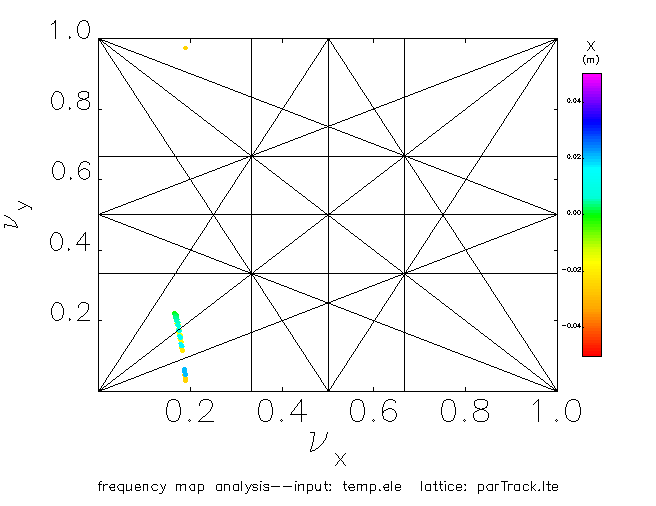

In [27]:
Image(filename="partrack_tune.png")

### DA

In [28]:
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880)
# parallel only supports n-line
er.dynap(n_lines=51)

In [29]:
sddsp = SDDS(sif,"temp.aper",0)
sddsp.sddsplot_base(col="x,y",file1=sddsp.filename, device='png',output="partrack_aper.png")

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp.aper -col=x,y temp.aper -device=png -output=partrack_aper.png


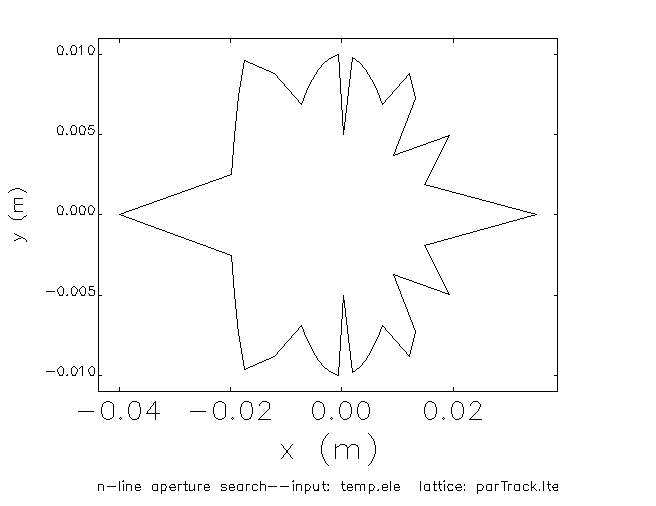

In [30]:
Image(filename="partrack_aper.png")

### Vary Element with input table

#### Mode: Row

In [31]:
# create the input table for vary element 
datasetdc = {
        "Q1" : [1.786022448154-0.01,1.786022448154+0.01],
        "Q2" : [2.295915530046-0.01,2.295915530046+0.01],
     
 }

# create simulation object
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)

# generate particle grid for tracking
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=3
                                   )

# Track with vary - using mode row -> number of combinations is equal to the number of rows
er.track_vary(varydict=datasetdc,varyitemlist=['k1',"k1"],n_passes=2**8, add_watch_start=True, mode='row')

# laod the data
sdds = SDDS(sif, "temp-001.wq",0)
sdds.process_scan()
data = sdds.readParticleData()
data.head()

880.0
Shape: (243, 6) - Number of paritcles: 243 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsprocess -define=column,step,Step temp-001.wq temp-001_processed.wq
Warning - auto filename set
Changed from temp-001.wq to temp-001_processed.wq
Warning - auto filename set
Changed from temp-001_processed.wq to temp-001_processed.wq.txt
Warning - auto filetype set
Changed from 0 to 1


,x,xp,y,yp,t,p,dt,particleID,step,Turn
0,0.0,0.0,0.0,0.00000,0.00000,1722.116751,0.00000,1,1.0,1
1,0.0,0.0,0.0,0.00000,0.00005,1722.116751,0.00005,2,1.0,1
2,0.0,0.0,0.0,0.00000,0.00010,1722.116751,0.00010,3,1.0,1
3,0.0,0.0,0.0,0.00005,0.00000,1722.116751,0.00000,4,1.0,1
4,0.0,0.0,0.0,0.00005,0.00005,1722.116751,0.00005,5,1.0,1


In [32]:
# inspect input table file
sdds = SDDS(sif, "temp.sdds",0)
sdds.getColumnValues()

,Q1,Q2
0,1.776022,2.285916
1,1.796022,2.305916


In [33]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    graph="dot,type=2",
    groupby='page',
    layout='2,1',
    split='parameterChange=Step,width=1,start=0',
    sep='page',
    columnNames="x,xp",
    legend='param=Step',
    device='png',
    output="partrack_vary_rect_mode_row.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -graph=dot,type=2 -groupby=page -layout=2,1 -split=parameterChange=Step,width=1,start=0 -sep=page -columnNames=x,xp -legend=param=Step -device=png -output=partrack_vary_rect_mode_row.png


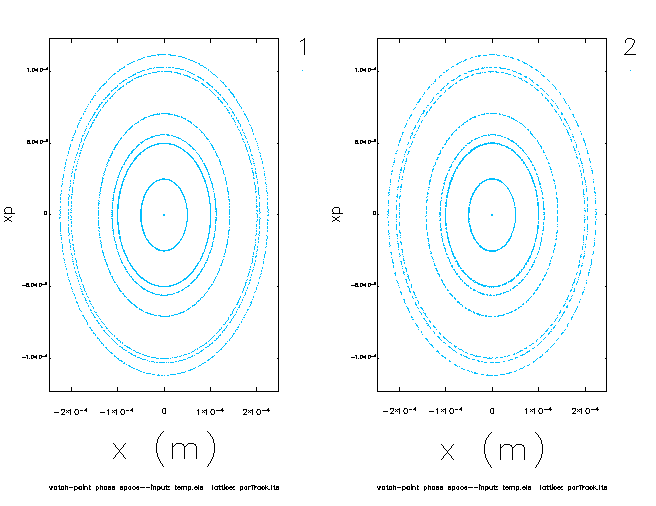

In [34]:
Image(filename='partrack_vary_rect_mode_row.png') 

<IPython.core.display.Javascript object>


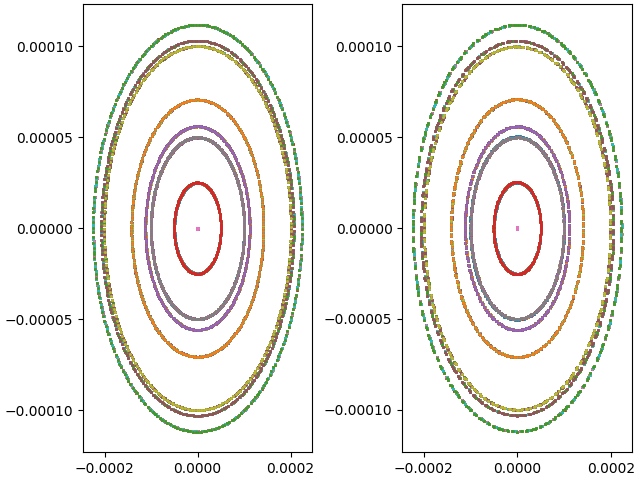

In [35]:
nsteps = int(data.step.max())

fig = plt.figure(constrained_layout=True)

gs= fig.add_gridspec(nsteps//2+nsteps%2, 2)

for i in [1.0*n for n in range(1,nsteps+1)]:
    ax = fig.add_subplot(gs[int(i-1)//2,int(i-1)%2])
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    for name, group in data.loc[data.step==i].groupby("particleID"):
        ax.scatter(group["x"],group["xp"],s=1, label=name)

plt.show()

#### Mode: table

In [36]:
# create the input table for vary element 
datasetdc = {
        "Q1" : [1.786022448154-0.01,1.786022448154+0.01],
        "Q2" : [2.295915530046-0.01,2.295915530046+0.01],
     
 }

# create simulation object
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)

# generate particle grid for tracking
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=3
                                   )

# Track with vary - using mode row -> number of combinations is equal to the number of rows
er.track_vary(varydict=datasetdc,varyitemlist=['k1',"k1"],n_passes=2**8, add_watch_start=True, mode='table')

# laod the data
sdds = SDDS(sif, "temp-001.wq",0)
sdds.process_scan()
data = sdds.readParticleData()
data.head()

880.0
Shape: (243, 6) - Number of paritcles: 243 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsprocess -define=column,step,Step temp-001.wq temp-001_processed.wq
Warning - auto filename set
Changed from temp-001.wq to temp-001_processed.wq
Warning - auto filename set
Changed from temp-001_processed.wq to temp-001_processed.wq.txt
Warning - auto filetype set
Changed from 0 to 1


,x,xp,y,yp,t,p,dt,particleID,step,Turn
0,0.0,0.0,0.0,0.00000,0.00000,1722.116751,0.00000,1,1.0,1
1,0.0,0.0,0.0,0.00000,0.00005,1722.116751,0.00005,2,1.0,1
2,0.0,0.0,0.0,0.00000,0.00010,1722.116751,0.00010,3,1.0,1
3,0.0,0.0,0.0,0.00005,0.00000,1722.116751,0.00000,4,1.0,1
4,0.0,0.0,0.0,0.00005,0.00005,1722.116751,0.00005,5,1.0,1


In [37]:
# inspect input table file
sdds = SDDS(sif, "temp.sdds",0)
sdds.getColumnValues()

,Q1,Q2
0,1.776022,2.285916
1,1.796022,2.305916


In [38]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    graph="dot,type=2",
    groupby='page',
    layout='2,2',
    split='parameterChange=Step,width=1,start=0',
    sep='page',
    columnNames="x,xp",
    legend='param=Step',
    device='png',
    output="partrack_vary_rect_mode_table.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -graph=dot,type=2 -groupby=page -layout=2,2 -split=parameterChange=Step,width=1,start=0 -sep=page -columnNames=x,xp -legend=param=Step -device=png -output=partrack_vary_rect_mode_table.png


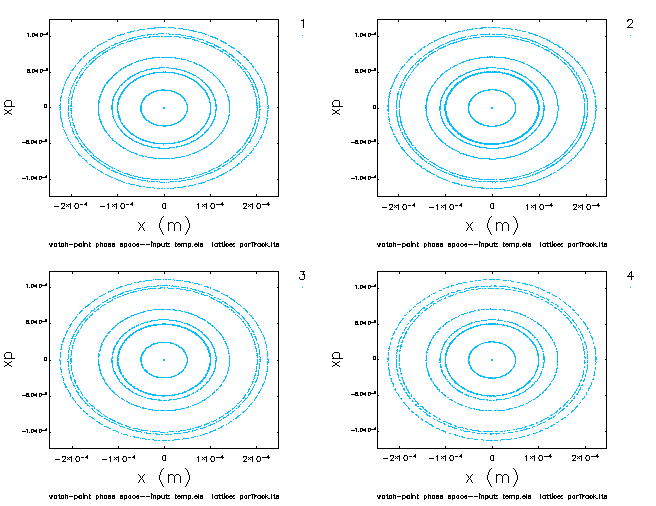

In [39]:
Image(filename="partrack_vary_rect_mode_table.png")

<IPython.core.display.Javascript object>


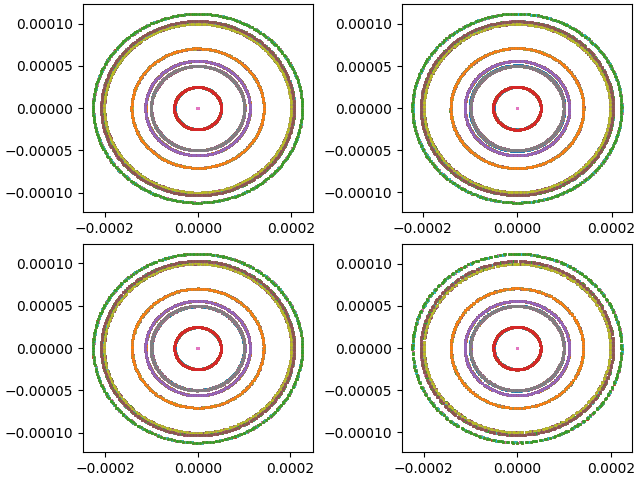

In [40]:
nsteps = int(data.step.max())

fig = plt.figure(constrained_layout=True)

gs= fig.add_gridspec(nsteps//2+nsteps%2, 2)

for i in [1.0*n for n in range(1,nsteps+1)]:
    ax = fig.add_subplot(gs[int(i-1)//2,int(i-1)%2])
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    for name, group in data.loc[data.step==i].groupby("particleID"):
        ax.scatter(group["x"],group["xp"],s=1, label=name)

plt.show()

### Vary Elment with vary commands

#### Mode: row

In [41]:
# create the input table for vary element 
varyset = [
    {'name': "Q1", 'item':'K1', 'initial': 1.786022448154-0.01,'final':1.786022448154+0.01, 'index_limit': 2},
    {'name': "Q2", 'item':'K1', 'initial': 2.295915530046-0.01,'final':2.295915530046+0.01, 'index_limit': 2}
]


# create simulation object
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)

# generate particle grid for tracking
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=3
                                   )
er.table_scan(varyset,mode='row',add_watch_start=True)


# laod the data
sdds = SDDS(sif, "temp-001.wq",0)
sdds.process_scan()
data = sdds.readParticleData()
data.head()

880.0
Shape: (243, 6) - Number of paritcles: 243 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsprocess -define=column,step,Step temp-001.wq temp-001_processed.wq
Warning - auto filename set
Changed from temp-001.wq to temp-001_processed.wq
Warning - auto filename set
Changed from temp-001_processed.wq to temp-001_processed.wq.txt
Warning - auto filetype set
Changed from 0 to 1


,x,xp,y,yp,t,p,dt,particleID,step,Turn
0,0.0,0.0,0.0,0.00000,0.00000,1722.116751,0.00000,1,1.0,1
1,0.0,0.0,0.0,0.00000,0.00005,1722.116751,0.00005,2,1.0,1
2,0.0,0.0,0.0,0.00000,0.00010,1722.116751,0.00010,3,1.0,1
3,0.0,0.0,0.0,0.00005,0.00000,1722.116751,0.00000,4,1.0,1
4,0.0,0.0,0.0,0.00005,0.00005,1722.116751,0.00005,5,1.0,1


In [42]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    graph="dot,type=2",
    groupby='page',
    layout='2,2',
    split='parameterChange=Step,width=1,start=0',
    sep='page',
    columnNames="x,xp",
    legend='param=Step',
    device='png',
    output="partrack_varycommand_rect_mode_row_.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -graph=dot,type=2 -groupby=page -layout=2,2 -split=parameterChange=Step,width=1,start=0 -sep=page -columnNames=x,xp -legend=param=Step -device=png -output=partrack_varycommand_rect_mode_row_.png


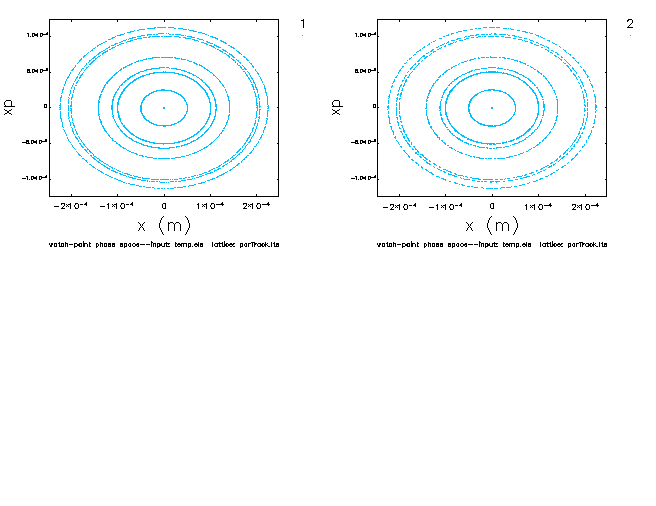

In [43]:
Image(filename="partrack_varycommand_rect_mode_row_.png")

<IPython.core.display.Javascript object>


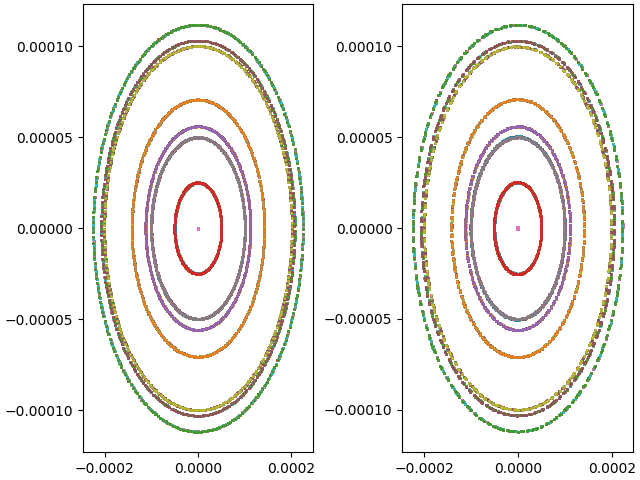

In [44]:
nsteps = int(data.step.max())

fig = plt.figure(constrained_layout=True)

gs= fig.add_gridspec(nsteps//2+nsteps%2, 2)

for i in [1.0*n for n in range(1,nsteps+1)]:
    ax = fig.add_subplot(gs[int(i-1)//2,int(i-1)%2])
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    for name, group in data.loc[data.step==i].groupby("particleID"):
        ax.scatter(group["x"],group["xp"],s=1, label=name)

plt.show()

#### Mode: table

In [45]:
# create the input table for vary element 
varyset = [
    {'name': "Q1", 'item':'K1', 'initial': 1.786022448154-0.01,'final':1.786022448154+0.01, 'index_limit': 2},
    {'name': "Q2", 'item':'K1', 'initial': 2.295915530046-0.01,'final':2.295915530046+0.01, 'index_limit': 2}
]


# create simulation object
er = ElegantRun(sif,lattice, parallel=True, use_beamline="par", energy=880.00)

# generate particle grid for tracking
er.generate_sdds_particle_inputfile(grid_type='rectangular', p_min=1e-6, p_max=1e-2, 
                                    pcentralmev=er.kwargs.get('energy'),
                                    NPOINTS=3
                                   )
er.table_scan(varyset,mode='table',add_watch_start=True)


# laod the data
sdds = SDDS(sif, "temp-001.wq",0)
sdds.process_scan()
data = sdds.readParticleData()
data.head()

880.0
Shape: (243, 6) - Number of paritcles: 243 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
Executing : 
/home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsprocess -define=column,step,Step temp-001.wq temp-001_processed.wq
Warning - auto filename set
Changed from temp-001.wq to temp-001_processed.wq
Warning - auto filename set
Changed from temp-001_processed.wq to temp-001_processed.wq.txt
Warning - auto filetype set
Changed from 0 to 1


,x,xp,y,yp,t,p,dt,particleID,step,Turn
0,0.0,0.0,0.0,0.00000,0.00000,1722.116751,0.00000,1,1.0,1
1,0.0,0.0,0.0,0.00000,0.00005,1722.116751,0.00005,2,1.0,1
2,0.0,0.0,0.0,0.00000,0.00010,1722.116751,0.00010,3,1.0,1
3,0.0,0.0,0.0,0.00005,0.00000,1722.116751,0.00000,4,1.0,1
4,0.0,0.0,0.0,0.00005,0.00005,1722.116751,0.00005,5,1.0,1


In [46]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    graph="dot,type=2",
    groupby='page',
    layout='2,2',
    split='parameterChange=Step,width=1,start=0',
    sep='page',
    columnNames="x,xp",
    legend='param=Step',
    device='png',
    output="partrack_varycommand_rect_mode_table_.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -graph=dot,type=2 -groupby=page -layout=2,2 -split=parameterChange=Step,width=1,start=0 -sep=page -columnNames=x,xp -legend=param=Step -device=png -output=partrack_varycommand_rect_mode_table_.png


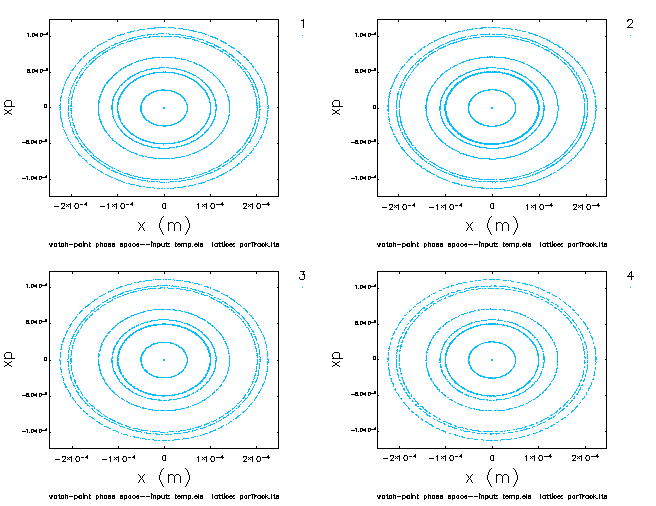

In [47]:
Image(filename="partrack_varycommand_rect_mode_table_.png")

### Radiation and RF effects

In [48]:
# use lattice from file
lattice = 'bii_simple.lte'

# run twiss to get gamma0 for generating particle input
er = ElegantRun(sif,lattice, parallel=True, use_beamline="ring", energy=1700.00)
twiss, twipar = er.findtwiss()

# on/off - momentum
gamma0 = twipar.pCentral

# initial coordinate grid for tracking
man_ranges= {
    0 : np.array([0,1e-6,1e-5,1e-4]),
    1 : [0],
    2 : 0,
    3 : 0,
    4 : 0,
    5 : gamma0 
}

# generate coordinate input file
er = ElegantRun(sif,lattice, parallel=True, use_beamline="ring", energy=1700.00)
er.generate_sdds_particle_inputfile(man_ranges=man_ranges)
er.track_simple(rad=False, rf=False, add_watch_start=True, total_voltage=1.5e6)

1700.0
Shape: (4, 6) - Number of paritcles: 4 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [49]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    columnNames="dt,p",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="bii_no_rad_no_rf_long.png"
)

sddsp.sddsplot_base(
    columnNames="x,xp",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="bii_no_rad_no_rf_long_xpx.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -columnNames=dt,p -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=bii_no_rad_no_rf_long.png
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -columnNames=x,xp -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=bii_no_rad_no_rf_long_xpx.png


In [50]:
# generate coordinate input file
er = ElegantRun(sif,lattice, parallel=True, use_beamline="ring", energy=1700.00)
er.generate_sdds_particle_inputfile(man_ranges=man_ranges)
er.track_simple(rad=True, rf=False, add_watch_start=True, total_voltage=1.5e6)

1700.0
Shape: (4, 6) - Number of paritcles: 4 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [51]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    columnNames="dt,p",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="bii_rad_no_rf_long.png"
)

sddsp.sddsplot_base(
    columnNames="x,xp",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="bii_rad_no_rf_long_xpx.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -columnNames=dt,p -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=bii_rad_no_rf_long.png
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -columnNames=x,xp -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=bii_rad_no_rf_long_xpx.png


In [52]:
# generate coordinate input file
er = ElegantRun(sif,lattice, parallel=True, use_beamline="ring", energy=1700.00)
er.generate_sdds_particle_inputfile(man_ranges=man_ranges)
er.track_simple(rad=True, rf=True, add_watch_start=True, total_voltage=1.5e6)

1700.0
Shape: (4, 6) - Number of paritcles: 4 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount


In [53]:
# quick plot
sddsp = SDDS(sif,"temp-001.wq",0)

sddsp.sddsplot_base(
    columnNames="dt,p",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="bii_rad_rf_long.png"
)

sddsp.sddsplot_base(
    columnNames="x,xp",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="png",
    output="bii_rad_rf_long_xpx.png"
)

Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -columnNames=dt,p -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=bii_rad_rf_long.png
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot temp-001.wq -columnNames=x,xp -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=png -output=bii_rad_rf_long_xpx.png


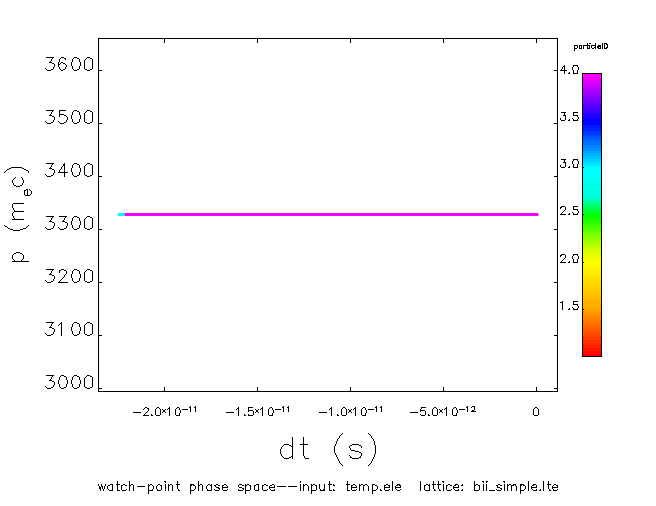

In [54]:
Image('bii_no_rad_no_rf_long.png')

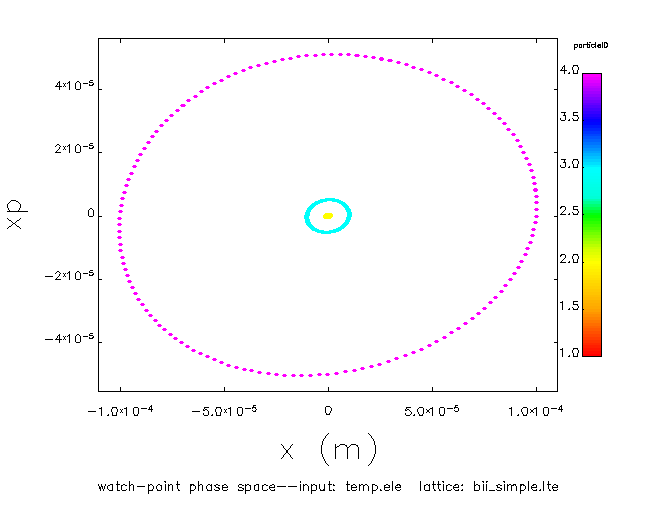

In [55]:
Image('bii_no_rad_no_rf_long_xpx.png')

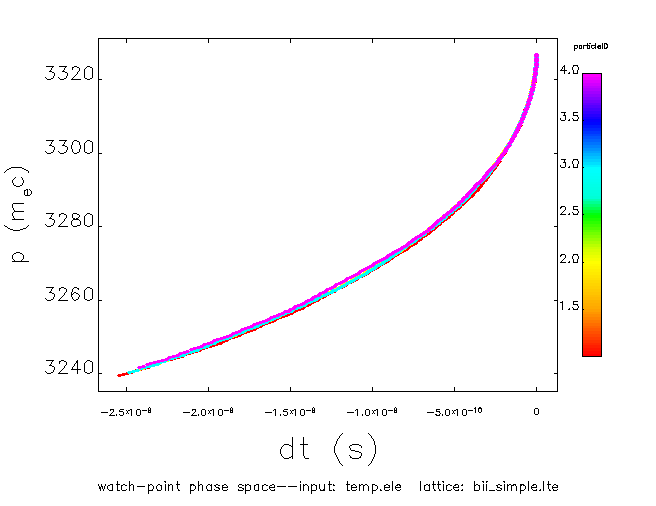

In [56]:
Image('bii_rad_no_rf_long.png')

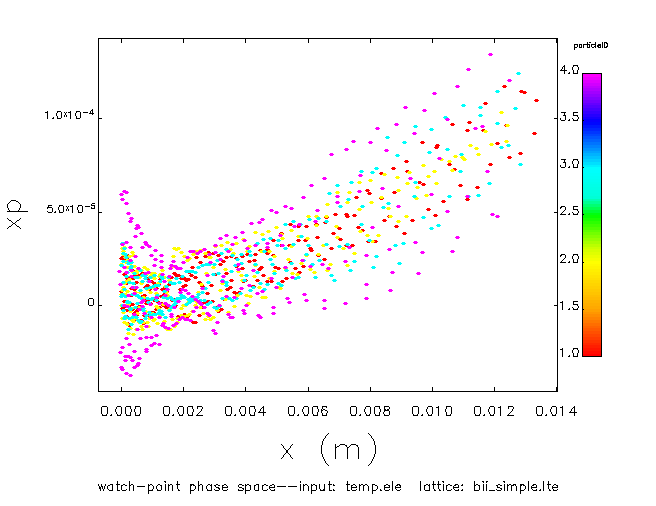

In [57]:
Image('bii_rad_no_rf_long_xpx.png')

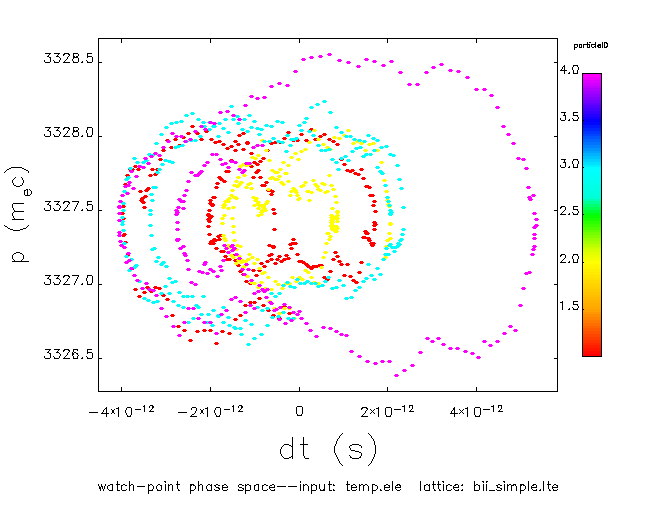

In [58]:
Image(filename="bii_rad_rf_long.png")

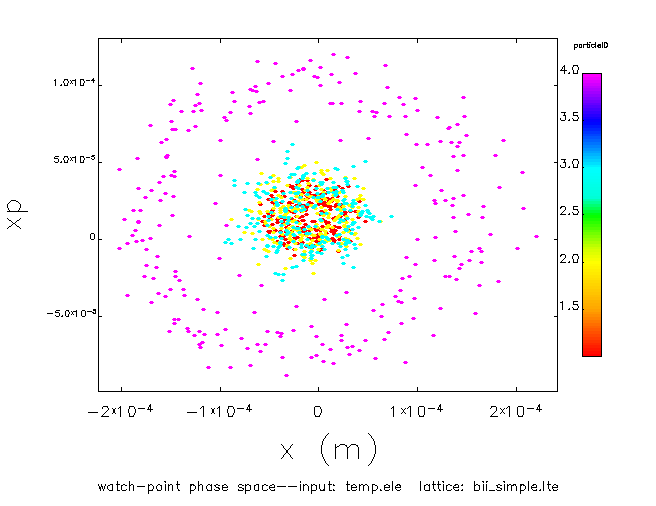

In [59]:
Image(filename="bii_rad_rf_long_xpx.png")